In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [4]:
!pip install gdown

In [13]:
!pip install diffusers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 10.8 MB/s eta 0:00:00


In [8]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Dataset

In [9]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = datasets.CelebA(root='celeba/', split="train", target_type='attr', download=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


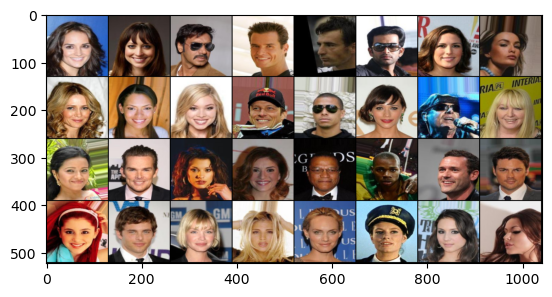

In [10]:
from matplotlib import pyplot as plt
x, y = next(iter(train_dataloader))

grid = make_grid(x, normalize=True, scale_each=False)
plt.imshow(grid.permute(1, 2, 0).numpy())

# Conditional Model w/ Diffusers

In [29]:
from diffusers import DDPMScheduler, UNet2DModel

device = "cuda" if torch.cuda.is_available() else "cpu"

logging.info("Using device: {}".format(device))

class ClassConditionedUnet(nn.Module):
    def __init__(self, class_attr_dim=40, class_emb_size=5, img_size=128):
        super().__init__()
        
        self.class_emb = nn.Linear(class_attr_dim, class_emb_size)
        
        self.model = UNet2DModel(
            sample_size=img_size, # Image resolution
            in_channels=3+class_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(32, 64, 64, 128),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
                "AttnDownBlock2D"
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )
        
    def forward(self, x, t, class_attr):
        bs, ch, w, h = x.shape
        
        # logging.info(f"X: {x.device}, t: {t.device}, class_attr: {class_attr.device}")
        
        class_cond = self.class_emb(class_attr.float()) # Shape (batch, 5)
        
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Shape (batch, 5, img_size, img_size)
        
        net_input = torch.cat([x, class_cond], dim=1) # Shape (batch, 8, img_size, img_size)
        
        return self.model(net_input, t).sample

2025-05-09 16:48:09,819 - INFO - Using device: cuda


# Training / Sampling

In [25]:
from accelerate import Accelerator

accelerator = Accelerator()

2025-05-09 16:47:40,916 - WARNING - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [40]:
n_epochs = 10

diffusion_model = ClassConditionedUnet(class_attr_dim=40, class_emb_size=5, img_size=128)

trainable_params = sum(
    p.numel() for p in diffusion_model.parameters() if p.requires_grad
)

print("total no.of parameters in unet model = ", trainable_params)

total no.of parameters in unet model =  4731312


In [46]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

In [47]:
train_dataloader, diffusion_model, noise_scheduler, optimizer = accelerator.prepare(
    train_dataloader,
    diffusion_model,
    noise_scheduler,
    optimizer
)

## Core Training Loop

In [ ]:
loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    for x,y in tqdm(train_dataloader):
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device) # Generate timestep for each batch
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        pred = diffusion_model(noisy_x, timesteps, y)
        
        loss = loss_fn(pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")
    torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/model_epoch_{epoch+1}_ckpt.pth")
    
plt.plot(losses)

  1%|          | 15/1272 [01:51<2:34:04,  7.35s/it]

In [37]:
torch.cuda.empty_cache()